In [1]:
import os
import torch
import numpy as np

import scanpy as sc
from anndata import AnnData

result_dir = "../edges/"
raw_type=False
use_edge=False

In [2]:
def read_data(sample,select=10,loss_threshold=10,normalize=False):
    results=torch.load(result_dir+"edges_"+sample+".pth")
    edges=results["edges"]
    if normalize:
        attention_score=torch.abs(torch.abs(results["attention_score"])/torch.sum(results["attention_score"],dim=-2,keepdim=True))
    else:
        attention_score=results["attention_score"]
        normalized_attention_score=torch.abs(torch.abs(results["attention_score"])/torch.sum(results["attention_score"],dim=-2,keepdim=True))
    print(attention_score.shape)
    position_x=results["position_x"]
    position_y=results["position_y"]
    cell_type_name=results["cell_type_name"]
    loss1=results["loss_all"].cpu()
    
    B,N=position_x.shape
    loss1=loss1.unsqueeze(dim=-1).repeat(1,select).reshape(-1).numpy()
    
    cell_type_target=[cell_type_name[i][0] for i in range(len(cell_type_name))]
    
    if normalize:
        indices=torch.topk(torch.sum(attention_score,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(attention_score,dim=-1),k=select,dim=-1))
    else:
        tmp=torch.abs(torch.abs(results["attention_score"])/torch.sum(torch.abs(results["attention_score"]),dim=-2,keepdim=True))
        indices=torch.topk(torch.sum(tmp,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(tmp,dim=-1),k=select,dim=-1))
    indices_tmp=torch.arange(0,indices.shape[0],1).unsqueeze(dim=-1).repeat(1,select)
    indices=torch.stack([indices_tmp.reshape(-1),indices.reshape(-1)],dim=0)

    if not use_edge:
        edges=attention_score
        print("not use edge",edges.shape)
    
    edges=edges[indices[0],indices[1],:].reshape(-1,edges.shape[-1]).numpy()
    attention_score=attention_score[indices[0],indices[1],:].reshape(-1,attention_score.shape[-1]).numpy()
    
    to_position_x=position_x[:,0:1].repeat(1,select).reshape(-1).numpy()
    to_position_y=position_y[:,0:1].repeat(1,select).reshape(-1).numpy()
    from_position_x=position_x[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    from_position_y=position_y[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    
    dx=position_x-position_x[:,0:1]
    dy=position_y-position_y[:,0:1]
    distances=torch.sqrt(torch.square(dx)+torch.square(dy))
    distances=distances[indices[0],indices[1]].reshape(-1).numpy()
    
    indices_np=indices.numpy()
    cell_types=np.array(cell_type_name)[:,1:][indices_np[0],indices_np[1]].reshape(B,select)
    print("number of cell types in this sample:",np.unique(np.array(cell_type_name)[:,0],return_counts=True))
    cell_types_pair=[]
    cell_types_target=[]
    flags=[]
    for i in range(cell_types.shape[0]):
        for j in range(cell_types.shape[1]):
            if not raw_type:
                cell_types_pair.append(cell_types[i][j]+"->"+cell_type_target[i])
                flags.append(cell_type_target[i]!=cell_types[i][j])
                cell_types_target.append(cell_type_target[i])
            else:
                cell_types_pair.append(cell_types[i][j].split(" ")[0]+"->"+cell_type_target[i].split(" ")[0])
                flags.append(cell_types[i][j].split(" ")[0]!=cell_type_target[i].split(" ")[0])
                cell_types_target.append(cell_type_target[i].split(" ")[0])

    print(edges.shape)
    adata = AnnData(edges)
    adata.obs['cell_type'] = cell_types_pair
    adata.obs['cell_type_target']=cell_types_target
    adata.obs['from_position_x'] = from_position_x
    adata.obs['from_position_y'] = from_position_y
    adata.obs['to_position_x'] = to_position_x
    adata.obs['to_position_y'] = to_position_y
    adata.obs['distance']=distances
    adata.obs['loss']=loss1
    # modify here
    adata.obsm["y"]=results["y"].repeat(1,select).reshape(results["y"].shape[0]*select,results["y"].shape[1]).numpy()
    adata.obsm["attention_score"]=attention_score
    
    adata=adata[adata.obs['loss']<loss_threshold,:]
    return adata

In [3]:
def plot(adata,color='cell_type',select_type_number=None,select_type=None):
    assert not ((select_type is None and select_type_number is None) and (select_type is not None and select_type_number is not None))
    
    if select_type_number is not None:
        unique=np.unique(adata.obs['cell_type'],return_counts=True)
        args = np.argsort(-unique[1])[:select_type_number]
        select_type = unique[0][args]
    print("selecting edge types:", select_type)
    
    flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
    adata_filtered=adata[flag,:]

    sc.pp.scale(adata_filtered)
    sc.tl.pca(adata_filtered)
    sc.pp.neighbors(adata_filtered)  # Compute the neighborhood graph
    sc.tl.umap(adata_filtered)  # Compute UMAP
    # Plot UMAP
    sc.pl.umap(adata_filtered, color=color)
    return adata_filtered

#adata_20=plot(adata,select_type_number=20)
#plot(adata,select_type_number=10)
#unique=np.unique(adata.obs['cell_type'],return_counts=True)
#print(unique[0][np.argsort(-unique[1])],unique[1][np.argsort(-unique[1])])

In [4]:
import matplotlib.pyplot as plt
#with plt.rc_context({'figure.figsize': (6,6)}):
    #sc.pl.umap(adata_20, color='cell_type')

['sample1_rep1', 'sample1_rep2'] ========
torch.Size([159224, 49, 321])
torch.return_types.topk(
values=tensor([[0.2037, 0.0960, 0.0931, 0.0685, 0.0622],
        [0.1695, 0.1403, 0.1144, 0.0713, 0.0356],
        [0.1294, 0.1220, 0.1049, 0.0634, 0.0625],
        ...,
        [0.1134, 0.1091, 0.1045, 0.0707, 0.0462],
        [0.1201, 0.1010, 0.0978, 0.0566, 0.0516],
        [0.0992, 0.0943, 0.0872, 0.0707, 0.0548]]),
indices=tensor([[ 0, 35,  1,  2,  3],
        [ 0,  8, 20,  3, 19],
        [ 2,  0,  1,  4,  3],
        ...,
        [ 4,  1,  0, 11,  5],
        [ 0,  1,  4,  5, 28],
        [ 1,  0,  8,  5,  2]]))
not use edge torch.Size([159224, 49, 321])
number of cell types in this sample: (array(['B_Cells', 'CD4+_T_Cells', 'CD8+_T_Cells', 'DCIS_1', 'DCIS_2',
       'Endothelial', 'IRF7+_DCs', 'Invasive_Tumor', 'LAMP3+_DCs',
       'Macrophages_1', 'Macrophages_2', 'Mast_Cells', 'Myoepi_ACTA2+',
       'Myoepi_KRT15+', 'Perivascular-Like', 'Prolif_Invasive_Tumor',
       'Stromal', 

/tmp/ipykernel_2455085/3511959657.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/w

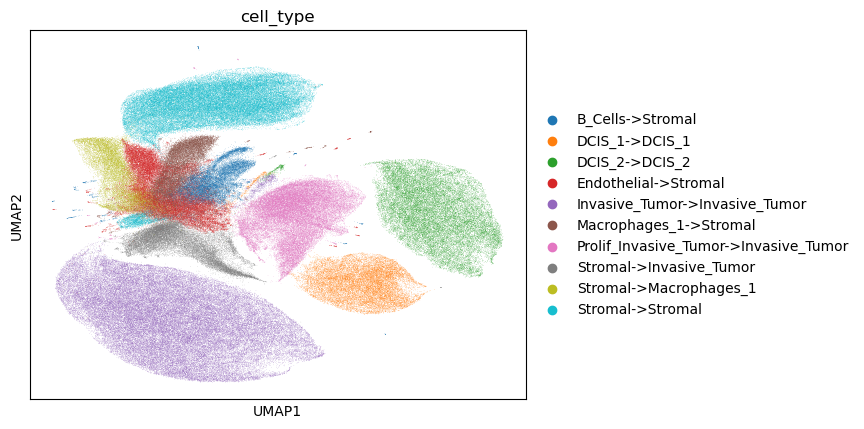

selecting edge types: ['Invasive_Tumor->Invasive_Tumor' 'Stromal->Stromal'
 'Prolif_Invasive_Tumor->Invasive_Tumor' 'Endothelial->Stromal'
 'DCIS_2->DCIS_2' 'Macrophages_1->Stromal' 'Stromal->Invasive_Tumor'
 'DCIS_1->DCIS_1' 'B_Cells->Stromal' 'Stromal->Macrophages_1']


/tmp/ipykernel_2455085/3511959657.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


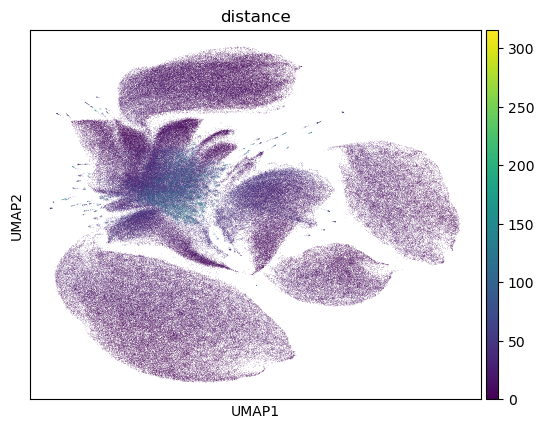

[['Invasive_Tumor->Invasive_Tumor', 'Stromal->Stromal', 'Prolif_Invasive_Tumor->Invasive_Tumor', 'Endothelial->Stromal', 'DCIS_2->DCIS_2', 'Macrophages_1->Stromal', 'Stromal->Invasive_Tumor', 'DCIS_1->DCIS_1', 'B_Cells->Stromal', 'Stromal->Macrophages_1', 'Unlabeled->Stromal', 'Stromal->Endothelial', 'Macrophages_2->Stromal', 'Myoepi_ACTA2+->DCIS_1', 'Invasive_Tumor->DCIS_1', 'Invasive_Tumor->Prolif_Invasive_Tumor', 'Endothelial->Endothelial', 'CD8+_T_Cells->Stromal', 'DCIS_1->DCIS_2', 'Invasive_Tumor->Stromal', 'Macrophages_1->Macrophages_1', 'CD4+_T_Cells->CD4+_T_Cells', 'Myoepi_ACTA2+->Myoepi_ACTA2+', 'Myoepi_ACTA2+->Stromal', 'Macrophages_1->Invasive_Tumor', 'Stromal->B_Cells', 'Stromal->CD8+_T_Cells', 'DCIS_1->Myoepi_ACTA2+', 'Stromal->CD4+_T_Cells', 'Myoepi_ACTA2+->DCIS_2', 'CD4+_T_Cells->Stromal', 'CD8+_T_Cells->CD4+_T_Cells', 'Stromal->Myoepi_ACTA2+', 'DCIS_1->Invasive_Tumor', 'CD4+_T_Cells->CD8+_T_Cells', 'Endothelial->Invasive_Tumor', 'Myoepi_KRT15+->DCIS_2', 'Unlabeled->Inva

/tmp/ipykernel_2455085/3511959657.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/w

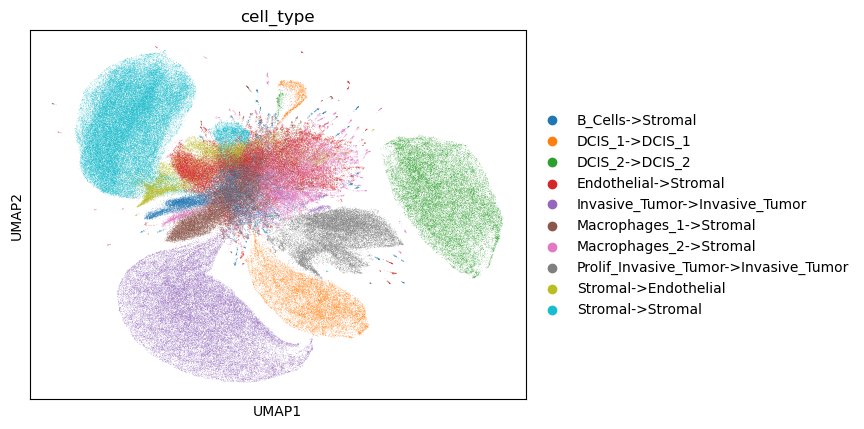

selecting edge types: ['Stromal->Stromal' 'Invasive_Tumor->Invasive_Tumor'
 'Endothelial->Stromal' 'DCIS_2->DCIS_2' 'Macrophages_1->Stromal'
 'Prolif_Invasive_Tumor->Invasive_Tumor' 'Macrophages_2->Stromal'
 'B_Cells->Stromal' 'DCIS_1->DCIS_1' 'Stromal->Endothelial']


/tmp/ipykernel_2455085/3511959657.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


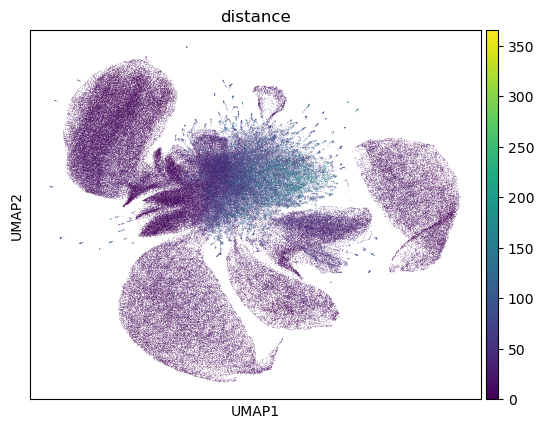

[['Stromal->Stromal', 'Invasive_Tumor->Invasive_Tumor', 'Endothelial->Stromal', 'DCIS_2->DCIS_2', 'Macrophages_1->Stromal', 'Prolif_Invasive_Tumor->Invasive_Tumor', 'Macrophages_2->Stromal', 'B_Cells->Stromal', 'DCIS_1->DCIS_1', 'Stromal->Endothelial', 'Unlabeled->Stromal', 'Stromal->Invasive_Tumor', 'Stromal->Macrophages_1', 'Myoepi_ACTA2+->DCIS_1', 'Endothelial->Endothelial', 'Myoepi_ACTA2+->Myoepi_ACTA2+', 'Myoepi_ACTA2+->Stromal', 'CD8+_T_Cells->Stromal', 'DCIS_1->DCIS_2', 'Macrophages_1->Macrophages_1', 'Stromal->B_Cells', 'CD4+_T_Cells->CD4+_T_Cells', 'Stromal->CD8+_T_Cells', 'DCIS_1->Myoepi_ACTA2+', 'Invasive_Tumor->Stromal', 'Stromal->Myoepi_ACTA2+', 'Invasive_Tumor->Prolif_Invasive_Tumor', 'Myoepi_ACTA2+->DCIS_2', 'CD4+_T_Cells->Stromal', 'Stromal->CD4+_T_Cells', 'CD8+_T_Cells->CD4+_T_Cells', 'CD4+_T_Cells->CD8+_T_Cells', 'Myoepi_KRT15+->DCIS_2', 'Stromal->Macrophages_2', 'Myoepi_KRT15+->Myoepi_KRT15+', 'DCIS_2->DCIS_1', 'Macrophages_1->Invasive_Tumor', 'CD8+_T_Cells->CD8+_T_C

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
import pandas as pd
samples=['sample1_rep1', 'sample1_rep2']

adata_list=[]
for samplei in samples:
    print(samples,"="*8)
    adata=read_data(samplei,select=5)
    adata_filtered=plot(adata,select_type_number=10)
    plot(adata,color="distance",select_type_number=10)
    adata_list.append(adata)
    
    unique=np.unique(adata.obs['cell_type'],return_counts=True)
    unique=[unique[0][np.argsort(-unique[1])].tolist(),unique[1][np.argsort(-unique[1])].tolist()]
    print(unique)
    torch.save(unique,"../edges/"+samplei+"_unique.pth")

merged_adata = sc.concat(adata_list, label="batch")
merged_adata.write('../edges/all.h5ad')